### Modeling and visualizing dynamics of COVID cases in Maryland counties
#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import html5lib
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-05-01


In [3]:
# change to local directory to save files


In [4]:
# import latest MD county counts
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_county_covid.csv'
md_county=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)
md_p_today=md_county.iloc[-1]
md_p_today=md_p_today[0:-9]

In [5]:
md_p_today.tail()

Talbot           35
Washington      216
Wicomico        425
Worcester        65
Total         23472
Name: 57, dtype: object

In [6]:
# import additional data

# hospitalization and deaths counts for Maryland
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_covid_H.csv'
md_xtra=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)

# deaths counts for all counties
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_covid_D.csv'
md_d=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)
md_d_today=md_d.iloc[-1]
md_d_today=md_d_today.iloc[0:-8]

# maryland population demographics
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_2019_pop.csv'
md_pop=pd.read_csv(url,sep=',',header='infer',index_col=0)

In [7]:
md_county.tail()

,Date,Allegany,Anne Arundel,Baltimore City,Baltimore County,Calvert,Caroline,Carroll,Cecil,Charles,...,Total,Female,Male,AA,Asian,White,Hispanic,Other,Data not available,Negative
53,2020-04-27,114,1544,1933,2548,138,68,403,163,529,...,19487,10460.0,9027.0,7085.0,384.0,4498.0,3077.0,752.0,3691.0,85489.0
54,2020-04-28,115,1571,1977,2631,139,69,416,163,539,...,20113,10750.0,9363.0,7432.0,424.0,4708.0,3309.0,721.0,3519.0,87672.0
55,2020-04-29,116,1662,2014,2740,142,69,421,164,551,...,20849,11130.0,9719.0,7615.0,434.0,4808.0,3473.0,747.0,3772.0,90080.0
56,2020-04-30,118,1725,2068,2831,150,71,436,167,564,...,21742,11595.0,10147.0,7821.0,459.0,4935.0,3651.0,793.0,4083.0,92617.0
57,2020-05-01,118,1807,2162,3013,161,74,460,176,611,...,23472,12500.0,10972.0,8093.0,475.0,5147.0,3884.0,840.0,5033.0,97511.0


In [8]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [9]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [10]:
# date range of the graph
start_date = min(md_county['Date'])
end_date = max(md_county['Date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-05 to 2020-05-01


In [11]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)


# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [12]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]
xdata_hosp=np.array(range(len(dates)))[-11:]

In [13]:
# model fit for hosp
model_hosp = pd.DataFrame(index=['hosp'],columns=['a','b','c','model'])
model_hosp.fillna(0)

xdata=np.array(md_xtra.index)[17:]
ydata=np.array(md_xtra["Hospitalized"])[17:]

popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)

quad_lin_diff=(SSE_lin-SSE_quad)/SSE_lin*100
    
if quad_lin_diff<5:
    no_quad=1
else:
    no_quad=0
    
try:
    popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
    min_error=min(SSE_exp,SSE_quad,SSE_lin)
except:    
    min_error=min(SSE_quad,SSE_lin)

if (min_error==SSE_quad) and (no_quad==1):
    min_error=SSE_lin
    
if min_error == SSE_exp:
    model_hosp.loc['hosp',['a','b','c']]=popt_exp
    model_hosp.loc['hosp','model']='exp'
elif min_error == SSE_quad:
    model_hosp.loc['hosp',['a','b','c']]=popt_quad
    model_hosp.loc['hosp','model']='quad'
elif min_error == SSE_lin:
    model_hosp.loc['hosp',['a','b']]=popt_lin
    model_hosp.loc['hosp','model']='lin'

In [14]:
model_hosp

,a,b,c,model
hosp,1.41172,23.708,-1118.83,quad


In [15]:
# historical model fit for select counties
import math

counties_to_model=['Montgomery','Anne Arundel',"Prince Georges","Howard",'Baltimore City','Baltimore County','Total']
model_results_hist=pd.DataFrame(index=md_county.index[23:],columns=counties_to_model)
model_results_hist.fillna(0)

for date_indext in md_county.index[23:]:
    date_index=date_indext-4
    xdata=np.array(md_county.index)[date_index-9:date_index+1]
    for county in counties_to_model:
        ydata=np.array(md_county[county])[date_index-9:date_index+1]
        popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
        popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)

        quad_lin_diff=((SSE_lin/SSE_quad)-1)*100

        if quad_lin_diff<5:
            no_quad=1
        else:
            no_quad=0

        try:
            popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
            min_error=min(SSE_exp,SSE_quad,SSE_lin)
        except:    
            min_error=min(SSE_quad,SSE_lin)

        if (min_error==SSE_quad) and (no_quad==1):
            min_error=SSE_lin

        if min_error == SSE_quad:
            if popt_quad[0]>0:
                model_type = "Quadratic(up)"
                color='orange'
            else:
                model_type = "Quadratic(down)"
                color='green'
            #output = [popt_quad[0],popt_quad[1],popt_quad[2],model_type,color]
            #output=model_type
            output=color
        elif min_error == SSE_lin:
            #output = [popt_quad[0],popt_quad[1],"Linear",'g']
            #output="Linear"
            output="green"
        elif min_error == SSE_exp:
            #output = [popt_quad[0],popt_quad[1],"Exponential",'r']
            #output="Exponential"
            output="red"
        model_results_hist.loc[date_indext,county]=output

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [16]:
# model fit for select counties
import math

counties_to_model=['Montgomery','Anne Arundel',"Prince Georges","Howard",'Baltimore City','Baltimore County','Total']
model_results=pd.DataFrame(index=counties_to_model,columns=['a','b','c','model'])
model_results.fillna(0)

xdata=np.array(md_county.index)[-10:]
for county in counties_to_model:
    ydata=np.array(md_county[county])[-10:]
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    quad_lin_diff=((SSE_lin/SSE_quad)-1)*100
    print(county)
    print(quad_lin_diff)
    
    if quad_lin_diff<5:
        no_quad=1
    else:
        no_quad=0
    
    try:
        popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
        min_error=min(SSE_exp,SSE_quad,SSE_lin)
    except:    
        min_error=min(SSE_quad,SSE_lin)
    
    if (min_error==SSE_quad) and (no_quad==1):
        min_error=SSE_lin

    if min_error == SSE_quad:
        model_results.loc[county,['a','b','c']]=popt_quad
        model_results.loc[county,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'
    elif min_error == SSE_exp:
        model_results.loc[county,['a','b','c']]=popt_exp
        model_results.loc[county,'model']='exp'

Montgomery
8.67606914138
Anne Arundel
10.6088482243
Prince Georges
31.3067001313
Howard
0.35729853143
Baltimore City
15.6803667792
Baltimore County
2.50744183973
Total
1.55624207668


/Users/annakonstorum/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [17]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'Exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'Quadratic (up)'
        if model_results.loc[county]['a']<0:
            opt_model = "Quadratic (down)"
    else:
        func_use=lin_func
        opt_model = 'Linear'
    return func_use, opt_model

In [18]:
# hospitalization/positive case ratio
h_p=pd.DataFrame(md_xtra.loc[21:]["Hospitalized"]/md_county.loc[21:]["Total"])
h_p.columns=["Percent"]
h_p["Percent"] = [float("{:.3f}".format(100*item)) for item in h_p["Percent"]]
h_p[-4:-1]

,Percent
54,21.220
55,21.114
56,20.969


In [19]:
# hospitalization/positive case ratio
h_d=pd.DataFrame(md_d.loc[23:]["Total"]/md_county.loc[23:]["Total"])
h_d.columns=["Percent"]
h_d["Percent"] = [float("{:.3f}".format(100*item)) for item in h_d["Percent"]]
print("CFR for today", h_d.iloc[-1]["Percent"])

# positive to tested
p_n = pd.DataFrame(md_county.loc[23:]["Total"]/md_county.loc[23:]["Negative"])
p_n.columns=["Percent"]
p_n["Percent"] = [float("{:.3f}".format(100*item)) for item in p_n["Percent"]]
print("% positive for today", p_n.iloc[-1]["Percent"])
p_n.head()

CFR for today 4.678
% positive for today 24.071


,Percent
23,8.614
24,10.029
25,10.611
26,11.165
27,11.519


### Maryland model and dynamics

In [20]:
next_day = xdata_pred[-1]
next2_day = next_day+1; next3_day = next_day+2
sub = "[1] First cases in Maryland; [2] Bars, restaurants, gyms close; [3] Non-essential businesses close; [4] Stay-at-home order"

In [21]:
popt_state = model_results.loc["Total"][0:3]
func_use, opt_model = function_use("Total",model_results)

popt_hosp = model_hosp.loc["hosp"][0:3]
func_use_hosp, opt_model_hosp = function_use("hosp",model_hosp)

if opt_model=="Linear":
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1])

else:    
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1], popt_state[2])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1], popt_state[2])

if opt_model_hosp=="Linear":
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1])

else:
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])


loc = "Maryland cases"
locH = "Maryland hospitalizations"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


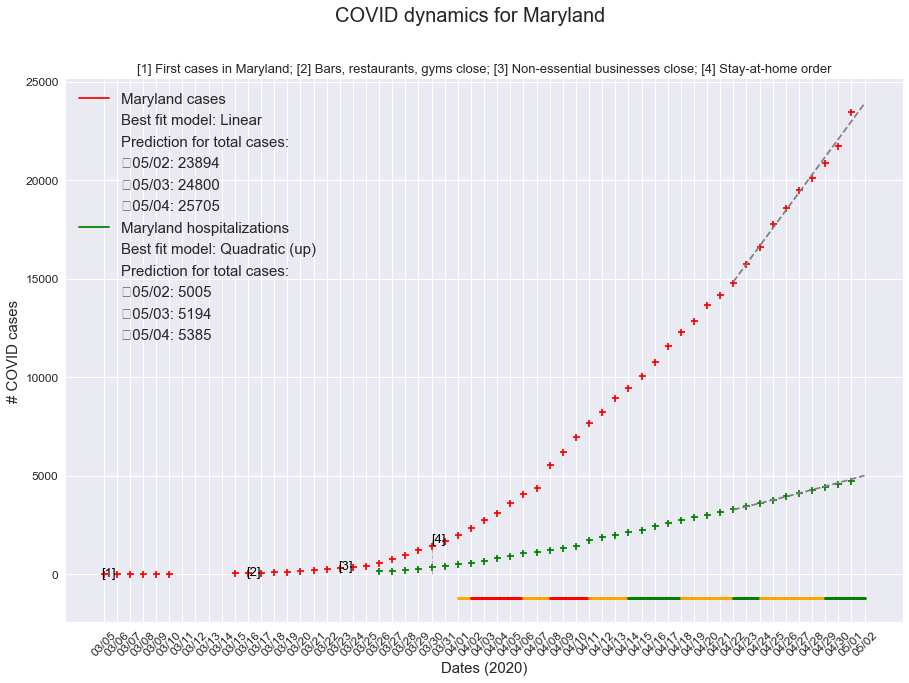

In [22]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label=loc, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases)), markersize=15),
                    Line2D([0], [0], marker='+', color='green', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model_hosp), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases_hosp)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases_hosp)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases_hosp)), markersize=15)]

plt.figure(figsize=(15,10))

if opt_model=='Linear':
    popt_state=popt_state[0:2]
if opt_model_hosp=="Linear":
    popt_hosp=popt_hosp[0:2]
    
plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(md_county.index,md_county['Total'],color='red',marker='+');

plt.plot(xdata_hosp, func_use_hosp(xdata_hosp, *popt_hosp), color='grey',linestyle='--');
plt.scatter(md_xtra.index[17:],md_xtra['Hospitalized'][17:],color='green',marker='+');

plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,90,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=370,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,360,"[3]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=1750,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.5,1740,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

bottom,top=plt.ylim()
for date_index in model_results_hist.index:
    #plt.plot([date_index,date_index+1],[bottom,bottom])
    color=model_results_hist.loc[date_index,"Total"]
    plt.plot([date_index,date_index+1],[bottom,bottom],color=color,linewidth=3.0)

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Maryland",fontsize=20);
plt.title(sub, fontsize=13);
plt.savefig("MD_COVID_update.png")

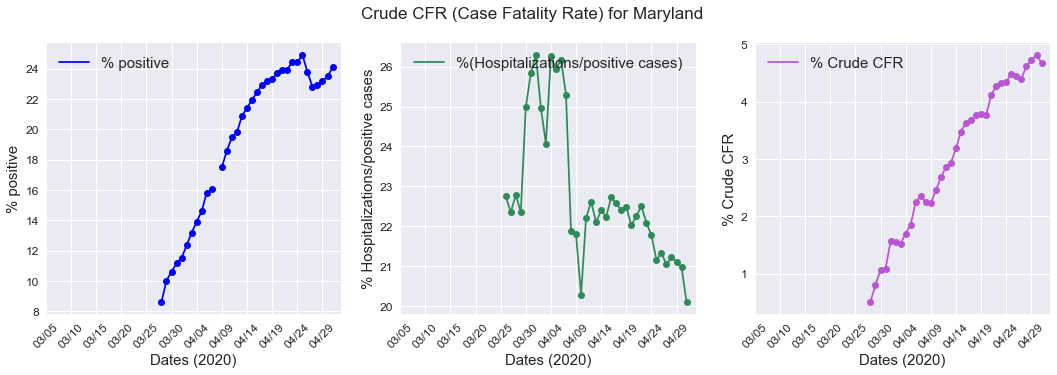

<Figure size 432x288 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(18,5))
fig.suptitle('Crude CFR (Case Fatality Rate) for Maryland',fontsize=17)


ax = fig.add_subplot(131)
legend_elements =  [Line2D([0], [0], marker='+', color='blue', label="% positive", markersize=15)]
plt.plot(p_n.index,p_n["Percent"],'o-',color='blue');  
plt.ylabel('% positive',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

ax = fig.add_subplot(132)
legend_elements =  [Line2D([0], [0], marker='+', color='seagreen', label="%(Hospitalizations/positive cases)", markersize=15)]
plt.plot(h_p.index,h_p["Percent"],'o-',color='seagreen');  
plt.ylabel('% Hospitalizations/positive cases',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

ax = fig.add_subplot(133)
legend_elements =  [Line2D([0], [0], marker='+', color='mediumorchid', label="% Crude CFR", markersize=15)]
plt.plot(h_d.index,h_d["Percent"],'o-',color='mediumorchid');   
plt.ylabel('% Crude CFR',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

plt.show()
plt.savefig('MD_COVID_percent.png')        

In [24]:
md_p_d=pd.DataFrame(index=md_d_today.index[1:],columns=['CFR'])
for county in md_d_today.index[1:]:
    c_d=md_d_today.loc[county]
    c_p=md_p_today.loc[county]
    if (c_d>1) or (c_p>20):
        p_d=md_d_today.loc[county]/md_p_today.loc[county]*100
        md_p_d.loc[county,'CFR']=p_d
    else:
        md_p_d.loc[county,'CFR']=-1
md_p_d.sort_values(by="CFR",inplace=True)
md_p_d = md_p_d[md_p_d["CFR"]>=0]

In [25]:
# getting pop
md_p_today=md_county.iloc[-1]
md_p_pop=pd.DataFrame(index=md_pop.index[0:-6],columns=["positive","pop","fraction"])
for county in md_pop.index[0:-6]:
    county_p = md_p_today.loc[county]
    county_pop=md_pop.loc[county]["Population_2019"]
    md_p_pop.loc[county]["positive"]=county_p
    md_p_pop.loc[county,"pop"]=county_pop
    md_p_pop.loc[county,"fraction"] = round(county_p/county_pop*100,4)

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Text(0.5, 1.0, 'Current Crude CFR')

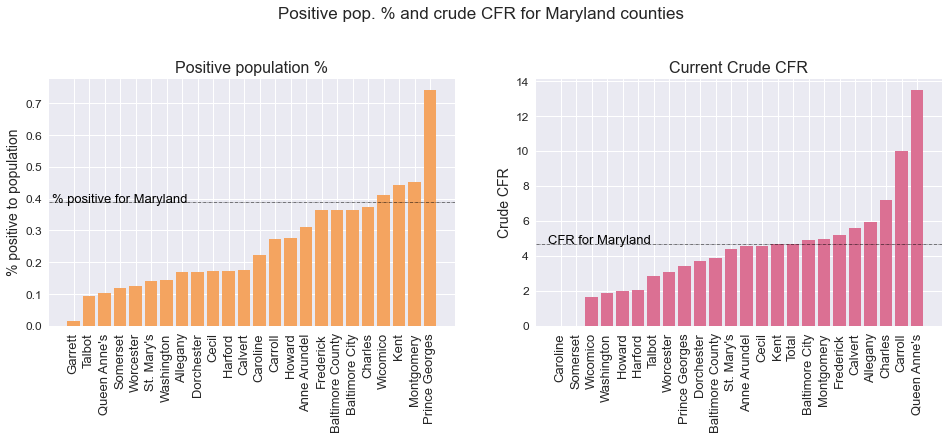

In [26]:
cfr_county=md_p_d["CFR"].values
county_frac=md_p_pop.iloc[0:-1]
county_frac.sort_values(by="fraction",inplace=True)
frac_county=county_frac["fraction"].values

fig = plt.figure(figsize=(16,10));
fig.suptitle('Positive pop. % and crude CFR for Maryland counties',fontsize=17)

ax = fig.add_subplot(221)
plt.bar(range(county_frac.shape[0]),frac_county,color='sandybrown')
plt.ylabel("% positive to population",fontsize=14)
plt.yticks(fontsize=12)
plt.axhline(y=md_p_pop.loc["Total"]["fraction"],color='black', linewidth=0.5,linestyle='-.');
plt.text(3,md_p_pop.loc["Total"]["fraction"]+0.01,"% positive for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center')
plt.xticks(range(county_frac.shape[0]),county_frac.index, rotation=90,fontsize=13);
plt.title("Positive population %",fontsize=16)

ax = fig.add_subplot(222)
plt.bar(range(md_p_d.shape[0]),cfr_county,color='palevioletred')
plt.ylabel("Crude CFR",fontsize=14)
plt.yticks(fontsize=12)
plt.axhline(y=h_d.iloc[-1]["Percent"],color='black', linewidth=0.5,linestyle='-.');
plt.text(2.5,h_d.iloc[-1]["Percent"]+0.2,"CFR for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center')
plt.xticks(range(md_p_d.shape[0]),md_p_d.index, rotation=90,fontsize=13);
plt.title("Current Crude CFR",fontsize=16)



#plt.show();
#plt.savefig('MD_COVID_county_stats.png');  

In [27]:
# reset
md_p_today=md_county.iloc[-1]
md_d_today=md_d.iloc[-1]

# gender diffs
female_pos_num=md_p_today["Female"]
male_pos_num=md_p_today["Male"]

female_pos_percent=round(female_pos_num/md_pop.loc["Female"]["Population_2019"]*100,4)
male_pos_percent = round(male_pos_num/md_pop.loc["Male"]["Population_2019"]*100,4)

cfr_fem = round(md_d_today["Female"]/female_pos_num*100,4)
cfr_male = round(md_d_today["Male"]/male_pos_num*100,4)

# ethnic diffs
ethnicity=["AA","Asian","White","Hispanic"]
ethnicity_plus=["AA","Asian","White","Hispanic","Other","Data not available"]
ethnicity_stats = pd.DataFrame(index=ethnicity_plus,columns=["pos","deaths","pos_percent","cfr"])
for item in ethnicity_plus:
    item_pos_num = md_p_today[item]
    item_d_num = md_d_today[item]
    if item in ethnicity:
        item_pop = md_pop.loc[item]["Population_2019"]
        item_pos_percent = round(item_pos_num/item_pop*100,4)
    item_cfr = round(item_d_num/item_pos_num*100,4)
    ethnicity_stats.loc[item,"pos"]=item_pos_num
    ethnicity_stats.loc[item,"deaths"]=item_d_num
    if item in ethnicity:
        ethnicity_stats.loc[item,"pos_percent"]=item_pos_percent
    ethnicity_stats.loc[item,"cfr"]=item_cfr

In [28]:
ethnicity_stats

,pos,deaths,pos_percent,cfr
AA,8093,436,0.4332,5.3874
Asian,475,38,0.1173,8
White,5147,436,0.1686,8.471
Hispanic,3884,69,0.6177,1.7765
Other,840,16,NaN,1.9048
Data not available,5033,103,NaN,2.0465


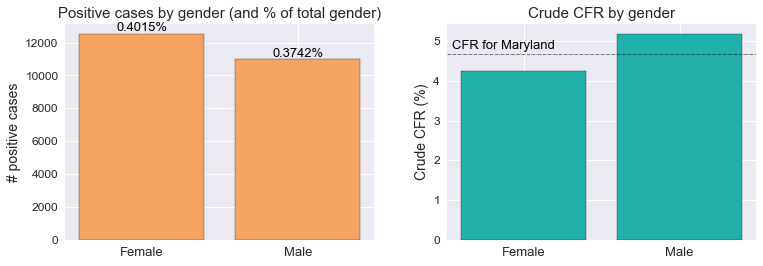

In [29]:
fig = plt.figure(figsize=(16,10));
#fig.suptitle('COVID cases in Maryland by gender',fontsize=17)

ax = fig.add_subplot(331)

plt.bar([0,1],[female_pos_num,male_pos_num],color=['sandybrown'],edgecolor='Black')
plt.ylabel("# positive cases",fontsize=14)
plt.yticks(fontsize=12)
fem_text=str(female_pos_percent)+"%"
male_text=str(male_pos_percent)+"%"

plt.text(0,female_pos_num,fem_text,rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')
plt.text(1,male_pos_num,male_text,rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')

plt.xticks([0,1],["Female","Male"],fontsize=13);
plt.title("Positive cases by gender (and % of total gender)",fontsize=15)

ax = fig.add_subplot(332)

plt.bar([0,1],[cfr_fem,cfr_male],color=['LightSeaGreen'],edgecolor='Black')
plt.ylabel("Crude CFR (%)",fontsize=14)
plt.yticks(fontsize=12)

plt.axhline(y=h_d.iloc[-1]["Percent"],color='black', linewidth=0.5,linestyle='-.');
plt.text(0.2,h_d.iloc[-1]["Percent"]+0.2,"CFR for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='right')

plt.xticks([0,1],["Female","Male"],fontsize=13);
plt.title("Crude CFR by gender",fontsize=15)

plt.tight_layout()
plt.subplots_adjust(top=1)
#plt.savefig('MD_COVID_gender.png')

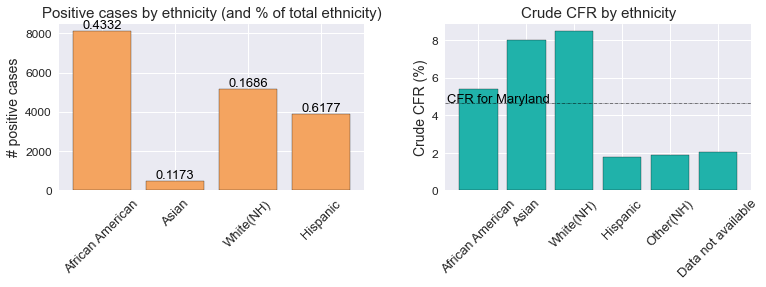

In [30]:
fig = plt.figure(figsize=(16,10));

ax = fig.add_subplot(331)
plt.bar([0,1,2,3],ethnicity_stats["pos"][0:4],color=['sandybrown'],edgecolor='Black')

plt.ylabel("# positive cases",fontsize=14)
plt.yticks(fontsize=12)

plt.text(0,ethnicity_stats.loc["AA"]["pos"],str(ethnicity_stats.loc["AA"]["pos_percent"]),rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')
plt.text(1,ethnicity_stats.loc["Asian"]["pos"],str(ethnicity_stats.loc["Asian"]["pos_percent"]),rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')
plt.text(2,ethnicity_stats.loc["White"]["pos"],str(ethnicity_stats.loc["White"]["pos_percent"]),rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')
plt.text(3,ethnicity_stats.loc["Hispanic"]["pos"],str(ethnicity_stats.loc["Hispanic"]["pos_percent"]),rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')

#plt.text(1,male_pos_num,male_text,rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')

plt.xticks([0,1,2,3],["African American", "Asian", "White(NH)","Hispanic"],rotation=45,fontsize=13)
plt.title("Positive cases by ethnicity (and % of total ethnicity)",fontsize=15)

ax = fig.add_subplot(332)
plt.bar([0,1,2,3,4,5],ethnicity_stats["cfr"],color=['LightSeaGreen'],edgecolor='Black')

plt.ylabel("Crude CFR (%)",fontsize=14)
plt.yticks(fontsize=12)

plt.axhline(y=h_d.iloc[-1]["Percent"],color='black', linewidth=0.5,linestyle='-.');
plt.text(1.5,h_d.iloc[-1]["Percent"]+0.2,"CFR for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='right')
#plt.text(1,male_pos_num,male_text,rotation=0,color='black',fontsize = 13,verticalalignment='bottom',horizontalalignment='center')

plt.xticks([0,1,2,3,4,5],["African American", "Asian", "White(NH)","Hispanic", "Other(NH)", "Data not available"],rotation=45,fontsize=13)
plt.title("Crude CFR by ethnicity",fontsize=15)

plt.tight_layout()
plt.subplots_adjust(top=1)
#plt.savefig('MD_COVID_types.png')

### Dynamics for two counties: Montgomery and Prince George's

In [31]:
poptM = model_results.loc["Montgomery"][0:3]
poptP = model_results.loc["Prince Georges"][0:3]

func_useM, opt_modelM = function_use("Montgomery",model_results)
func_useP, opt_modelP = function_use("Prince Georges",model_results)

if opt_modelM=="Linear":
    next_day_casesM = func_useM(next_day, poptM[0], poptM[1])
    next2_day_casesM = func_useM(next2_day, poptM[0], poptM[1])
    next3_day_casesM = func_useM(next3_day, poptM[0], poptM[1])

else:    
    next_day_casesM = func_useM(next_day, poptM[0], poptM[1], poptM[2])
    next2_day_casesM = func_useM(next2_day, poptM[0], poptM[1], poptM[2])
    next3_day_casesM = func_useM(next3_day, poptM[0], poptM[1], poptM[2])


if opt_modelP=="Linear":
    next_day_casesP = func_useP(next_day, poptP[0], poptP[1])
    next2_day_casesP = func_useP(next2_day, poptP[0], poptP[1])
    next3_day_casesP = func_useP(next3_day, poptP[0], poptP[1])

else:
    next_day_casesP = func_useP(next_day, poptP[0], poptP[1], poptP[2])
    next2_day_casesP = func_useP(next2_day, poptP[0], poptP[1], poptP[2])
    next3_day_casesP = func_useP(next3_day, poptP[0], poptP[1], poptP[2])

locM = "Montgomery County"
locP = "Prince George's County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


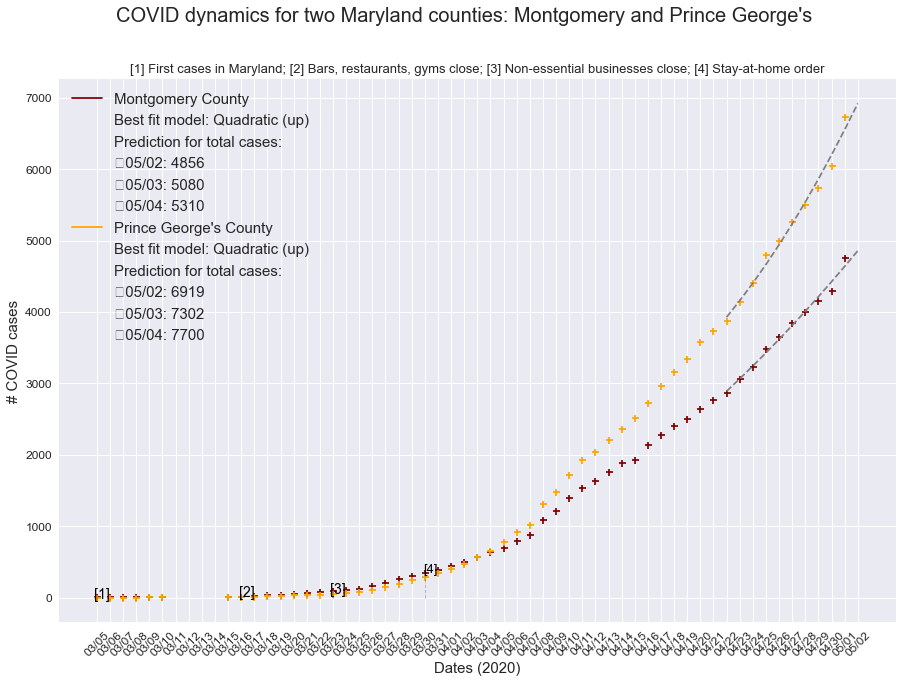

In [32]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locM, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelM), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesM)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locP, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelP), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesP)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesP)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesP)), markersize=15)]

plt.figure(figsize=(15,10));

if opt_modelM=='Linear':
    poptM=poptM[0:2]
if opt_modelP=="Linear":
    poptP=poptP[0:2]

plt.plot(xdata_pred, func_useM(xdata_pred, *poptM), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Montgomery'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useP(xdata_pred, *poptP), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Prince Georges'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,45,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=70,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,65,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=125,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,120,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=400,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,395,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Montgomery and Prince George's",fontsize=20); 
plt.title(sub, fontsize=13);

plt.savefig("MD_COVID_Mont_Prince_update.png")

### Dynamics for two counties: Howard and Anne Arundel

In [33]:
poptH = model_results.loc["Howard"][0:3]
poptA = model_results.loc["Anne Arundel"][0:3]

func_useH, opt_modelH = function_use("Howard",model_results)
func_useA, opt_modelA = function_use("Anne Arundel",model_results)

if opt_modelH=="Linear":
    next_day_casesH = func_useH(next_day, poptH[0], poptH[1])
    next2_day_casesH = func_useH(next2_day, poptH[0], poptH[1])
    next3_day_casesH = func_useH(next3_day, poptH[0], poptH[1])
else:
    next_day_casesH = func_useH(next_day, poptH[0], poptH[1], poptH[2])
    next2_day_casesH = func_useH(next2_day, poptH[0], poptH[1], poptH[2])
    next3_day_casesH = func_useH(next3_day, poptH[0], poptH[1], poptH[2])


if opt_modelA=="Linear":
    next_day_casesA = func_useA(next_day, poptA[0], poptA[1])
    next2_day_casesA = func_useA(next2_day, poptA[0], poptA[1])
    next3_day_casesA = func_useA(next3_day, poptA[0], poptA[1])

else:
    next_day_casesA = func_useA(next_day, poptA[0], poptA[1], poptA[2])
    next2_day_casesA = func_useA(next2_day, poptA[0], poptA[1], poptA[2])
    next3_day_casesA = func_useA(next3_day, poptA[0], poptA[1], poptA[2])

locH = "Howard County"
locA = "Anne Arundel County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


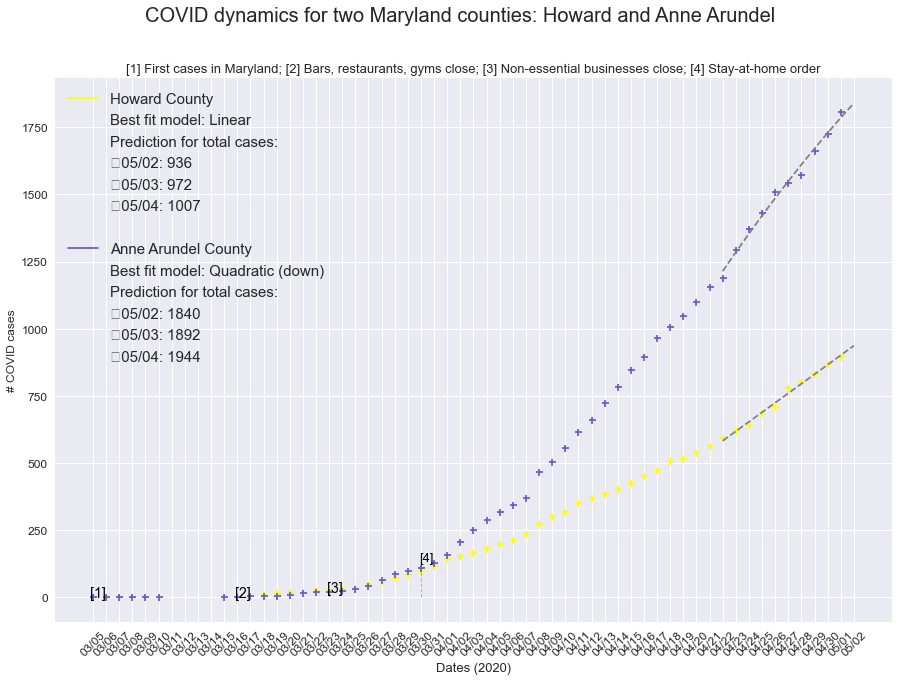

In [34]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='yellow', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelH), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesH)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='slateblue', label=locA, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelA), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesA)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesA)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesA)), markersize=15)]

if opt_modelH=='Linear':
    poptH=poptH[0:2]
if opt_modelA=="Linear":
    poptA=poptA[0:2]

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useH(xdata_pred, *poptH), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Howard'],color='yellow',marker='+')

plt.plot(xdata_pred, func_useA(xdata_pred, *poptA), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Anne Arundel'],color='slateblue',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,15,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,15,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=40,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,35,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=150,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,145,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Howard and Anne Arundel",fontsize=20);   
plt.title(sub, fontsize=13);

plt.savefig("MD_COVID_Howard_AA_update.png")

In [35]:
poptB1 = popt_state = model_results.loc["Baltimore City"][0:3]
poptB2 = popt_state = model_results.loc["Baltimore County"][0:3]

func_useB1, opt_modelB1 = function_use("Baltimore City",model_results)
func_useB2, opt_modelB2 = function_use("Baltimore County",model_results)

if opt_modelB1=="Linear":
    next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1])
    next2_day_casesB1 = func_useB1(next2_day, poptB1[0], poptB1[1])
    next3_day_casesB1 = func_useB1(next3_day, poptB1[0], poptB1[1])
    
else:
    next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1], poptB1[2])
    next2_day_casesB1 = func_useB1(next2_day, poptB1[0], poptB1[1], poptB1[2])
    next3_day_casesB1 = func_useB1(next3_day, poptB1[0], poptB1[1], poptB1[2])

if opt_modelB2=="Linear":
    next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1])
    next2_day_casesB2 = func_useB2(next2_day, poptB2[0], poptB2[1])
    next3_day_casesB2 = func_useB2(next3_day, poptB2[0], poptB2[1])

else:
    next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1], poptB2[2])
    next2_day_casesB2 = func_useB2(next2_day, poptB2[0], poptB2[1], poptB2[2])
    next3_day_casesB2 = func_useB2(next3_day, poptB2[0], poptB2[1], poptB2[2])


locB1 = "Baltimore City"
locB2 = "Baltimore County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


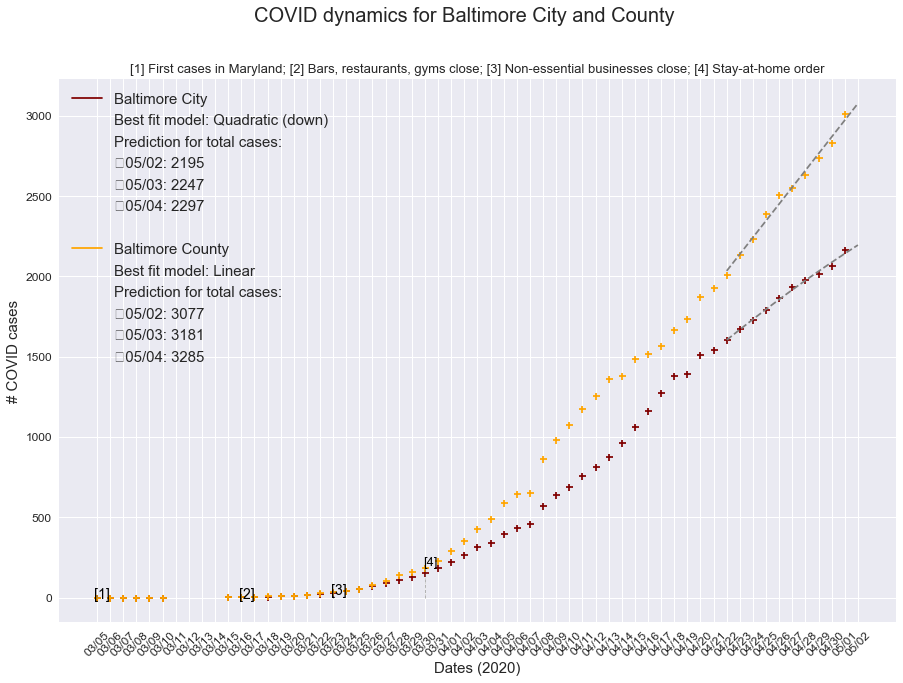

In [36]:
# BALTIMORE
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locB1, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB1), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB1)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locB2, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB2), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB2)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB2)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB2)), markersize=15)]


plt.figure(figsize=(15,10));

if opt_modelB1=='Linear':
    poptB1=poptB1[0:2]
if opt_modelB2=="Linear":
    poptB2=poptB2[0:2]

# Plot data + model
# model

plt.plot(xdata_pred, func_useB1(xdata_pred, *poptB1), color='grey',linestyle='--')
# data
plt.scatter(md_county.index,md_county['Baltimore City'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useB2(xdata_pred, *poptB2), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Baltimore County'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,20,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,20,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=45,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,45,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=225,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,220,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Baltimore City and County",fontsize=20);
plt.title(sub, fontsize=13);

plt.savefig("MD_COVID_Baltimore_update.png")